In [24]:
import pandas as pd
import datetime
import os
import numpy as np

# Load daily data and calculate monthly returns

In [ ]:
sectors = [x for x in os.listdir("workspace") if x.endswith(".csv")]

In [116]:
dfs = []
mindate = None
maxdate = None
for x in sectors:
    sym = x.replace(".csv", "").lower()
    df = pd.read_csv(f"workspace/{x}", parse_dates=['Date'])
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'totret_grossdvd', 'totret_netdvd']
    df = df[['date', 'totret_grossdvd']]
    df['sym'] = sym
    df.set_index('date', inplace=True)
    df = df.resample('BME').last()
    df['tr_pctchg'] = df['totret_grossdvd'].pct_change()
    df.reset_index(inplace=True)
    df.dropna(inplace=True)
    if mindate is None:
        mindate = df['date'].min()
    else:
        mindate = max(mindate, df['date'].min())
    
    if maxdate is None:
        maxdate = df['date'].max()
    else:
        maxdate = min(maxdate, df['date'].max())
        
    dfs.append(df)
    
trdf = pd.concat(dfs)

trdf = trdf[(trdf['date'] >= mindate) & (trdf['date'] <= maxdate)]

In [25]:
def trindex(vals):
    return ((1 + vals).cumprod() * 100)

# Load CPI Signals

In [27]:
dfcpi = pd.read_parquet("workspace/cpi_turnleaf_factors.pq").reset_index()
dfcpi['date'] = dfcpi['refdate'].apply(lambda x: datetime.date(x.year, x.month, 1))

# Construct forward returns for each ticker

In [105]:
def forward_returns(df, tickers, periods=[1, 2, 3, 6, 9, 12], col='totret_grossdvd'):
    for period in periods:
        df[f'rtn_{period}M'] = df.groupby('sym')[col].shift(-period) / df.groupby('sym').shift(0)[col] - 1
    return df

In [140]:
fwd_rtns = forward_returns(trdf, tickers=trdf['sym'].unique())
fwd_rtns['date'] = fwd_rtns['date'].apply(lambda x: pd.to_datetime(x).date())
fwd_rtns['refmonthyear'] = fwd_rtns['date'].apply(lambda x: x.strftime("%b.%Y").upper())
# fwd_rtns.to_clipboard()

In [393]:
dfcpi_fred = pd.read_parquet("workspace/cpi_fred_factors.pq").reset_index()

In [394]:
dfcpi_fred

,refmonthyear,date,usa.cpi,year,cpiyoy,cpi.hml,3M_rising,6M_rising,9M_rising,12M_rising,...,9Mchg,12Mchg,3M_rising_yoy,6M_rising_yoy,9M_rising_yoy,12M_rising_yoy,3Mchg_yoy,6Mchg_yoy,9Mchg_yoy,12Mchg_yoy
0,JAN.1914,1914-01-01,10.000,1914,2.040816,MED,False,False,False,False,...,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN
1,FEB.1914,1914-02-01,9.900,1914,1.020408,MED,False,False,False,False,...,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN
2,MAR.1914,1914-03-01,9.900,1914,1.020408,MED,False,False,False,False,...,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN
3,APR.1914,1914-04-01,9.800,1914,0.000000,LOW,False,False,False,False,...,NaN,NaN,False,False,False,False,-2.040816,NaN,NaN,NaN
4,MAY.1914,1914-05-01,9.900,1914,2.061856,MED,False,False,False,False,...,NaN,NaN,True,False,False,False,1.041448,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,JUL.2023,2023-07-01,305.691,2023,3.177780,HIGH,True,True,True,True,...,7.679,9.415,False,False,False,False,-1.752540,-3.232367,-4.567647,-5.347035
1315,AUG.2023,2023-08-01,307.026,2023,3.665112,HIGH,True,True,True,True,...,9.315,10.855,False,False,False,False,-0.382497,-2.370501,-3.445210,-4.597580
1316,SEP.2023,2023-09-01,307.789,2023,3.699698,HIGH,True,True,True,True,...,10.992,10.981,True,False,False,False,0.730520,-1.285276,-2.754703,-4.501972
1317,OCT.2023,2023-10-01,307.671,2023,3.241145,HIGH,True,True,True,True,...,8.501,9.659,True,False,False,False,0.063364,-1.689176,-3.169002,-4.504283


In [142]:
datemap = fwd_rtns[['refmonthyear', 'date']].drop_duplicates().copy()
datemap['date'] = datemap['date'].apply(lambda x: pd.to_datetime(x).date())

dfcpi_fred = pd.read_parquet("workspace/cpi_fred_factors.pq").reset_index()
cpi_factors = ['date', 'refmonthyear', '3M_rising_yoy', '6M_rising_yoy', '9M_rising_yoy', '12M_rising_yoy']
dfcpi_fred = dfcpi_fred[cpi_factors].copy()
dfcpi_fred['date'] = dfcpi_fred['date'].apply(lambda x: pd.to_datetime(x).date())

In [143]:
# merge fwd returns with cpi factor for identifying historical pairs
df_all = pd.merge(fwd_rtns, dfcpi_fred, on='refmonthyear', how='inner', suffixes=("", "_y")).drop("date_y", axis=1)
df_all['date'] = df_all['date'].apply(lambda x: pd.to_datetime(x).date())

In [158]:
rtn_cols = ['rtn_1M', 'rtn_2M', 'rtn_3M', 'rtn_6M', 'rtn_9M', 'rtn_12M']

dfrtn = df_all.pivot(columns='sym', index=['date', 'refmonthyear'], values=rtn_cols).reset_index()

## Construct Turnleaf Factors & merge with fwd returns

In [144]:
dfcpi_tleaf = pd.read_parquet("workspace/cpi_turnleaf_factors.pq").reset_index()
dfcpi_tleaf['date'] = dfcpi_tleaf['refdate'].apply(lambda x: pd.to_datetime(x).date())

tleaf_factor_cols = (['date', 'refdate', 'refmonthyear'] + 
                     [c for c in dfcpi_tleaf.columns if c.endswith('_rising_yoy')])

dftlX = dfcpi_tleaf[tleaf_factor_cols].copy()
dftlX['date'] = dftlX['date'].apply(lambda x: pd.to_datetime(x).date())

In [145]:
dftlX = pd.merge(dftlX, fwd_rtns, on="refmonthyear", how="inner", suffixes=("", "_y")).drop("date_y", axis=1)

In [146]:
dftlX.sort_values(['sym', 'date'], inplace=True)

# Construct rolling factors & rolling weights for long/short strategies  
Rolling weights using a lookback window are computed using FRED CPI to have greater historical lookback beyond that provided by Turnleaf Analytics data

In [90]:
def rolling_factor_means(df, datemap=None, factor='6M_rising_yoy', rtn_col='rtn_1M', lookback=24, min_periods=None): 
    
    if datemap is None:
        datemap = df[['refmonthyear', 'date']].drop_duplicates().copy()
        datemap['date'] = datemap['date'].apply(lambda x: pd.to_datetime(x).date())
    
    if min_periods is None:
        min_periods=lookback
    result = (df.groupby(['sym', factor])
              .rolling(lookback, on='refmonthyear', min_periods=min_periods)[rtn_col]
              .mean()
              ).reset_index()
    
    result = result.join(datemap.set_index('refmonthyear'), on='refmonthyear')
    return result

In [91]:
# construct rolling weights
rolling_results = {}

nperiods = [12, 24, 36, 48, 60]
factors = ['3M_rising_yoy', '6M_rising_yoy', '9M_rising_yoy', '12M_rising_yoy']
rtn_cols = ['rtn_1M', 'rtn_2M', 'rtn_3M', 'rtn_6M']
for nper in nperiods:
    for factor in factors:
        for rtn_col in rtn_cols:
            # nper = 12
            # factor = '6M_rising_yoy'
            # rtn_col = 'rtn_1M'
            print(f"Generating rolling factors for {factor} and {rtn_col} with {nper} period window")
            key = f"{factor}.{rtn_col}.window{nper}"            
            df = rolling_factor_means(df_all, factor=factor, rtn_col=rtn_col, lookback=nper)

            rolling_results[key] = df

Generating rolling factors for 3M_rising_yoy and rtn_1M with 12 period window
Generating rolling factors for 3M_rising_yoy and rtn_2M with 12 period window
Generating rolling factors for 3M_rising_yoy and rtn_3M with 12 period window
Generating rolling factors for 3M_rising_yoy and rtn_6M with 12 period window
Generating rolling factors for 6M_rising_yoy and rtn_1M with 12 period window
Generating rolling factors for 6M_rising_yoy and rtn_2M with 12 period window
Generating rolling factors for 6M_rising_yoy and rtn_3M with 12 period window
Generating rolling factors for 6M_rising_yoy and rtn_6M with 12 period window
Generating rolling factors for 9M_rising_yoy and rtn_1M with 12 period window
Generating rolling factors for 9M_rising_yoy and rtn_2M with 12 period window
Generating rolling factors for 9M_rising_yoy and rtn_3M with 12 period window
Generating rolling factors for 9M_rising_yoy and rtn_6M with 12 period window
Generating rolling factors for 12M_rising_yoy and rtn_1M with 12

# Trading Rule Functions

In [30]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [31]:
fm.fontManager.addfont("/Users/lcota/Library/Fonts/Raleway-Regular.ttf")
fm.fontManager.addfont("/Users/lcota/Library/Fonts/Raleway-Light.ttf")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Raleway'
plt.rcParams['font.style'] = "normal"

In [92]:
from collections import defaultdict

def get_weight(ticker, sigval, weights):
    if sigval is None:
        return 0
    return weights[sigval][ticker]
    
def zero():
    return 0

def make_weight_vector(tickers, default_weight=0.0):
    weights = {}    
    for t in tickers:
        weights[t] = default_weight
    
    weights = pd.Series(weights, name='weight')
    return weights

In [444]:
def get_longs_shorts(df, factor='6M_rising_yoy', fwd_rtn_months=1, lookback=24, 
                     long_only=True, npairs=2, short_spx=True):
    unique_dates = [d for d in df['date'].unique()]
    unique_refmonthyear = [d for d in df['refmonthyear'].unique()]
    
    start_dt = unique_dates[0]
    end_dt = unique_dates[lookback-1]
    df_prior = df[df['date'] <= start_dt].copy()
    
    start_index = lookback + fwd_rtn_months
    
    tickers = df['sym'].unique()
    
    longs_shorts = []    
    
    rtn_col=f'rtn_{fwd_rtn_months}M'
    for i in range(start_index, len(unique_dates)):
        start_dt = unique_dates[i- (lookback+fwd_rtn_months)]
        end_dt = unique_dates[i-(1 + fwd_rtn_months)]   
        index_dt = unique_dates[i]
        df_prior = df[(df['date'] >= start_dt) & (df['date'] <= end_dt)].copy()
        df_prior = df_prior[df_prior[factor].isna() == False]
        mean_returns = df_prior.groupby(['sym', factor], observed=True)[rtn_col].agg('mean')
        # print(mean_returns)
        excess_returns = mean_returns - mean_returns['spx']
        excess_returns = excess_returns.reset_index()
        
        ls = {}
        longs_rising = defaultdict(zero)
        shorts_rising = defaultdict(zero)
        longs_falling = defaultdict(zero)
        shorts_falling = defaultdict(zero)
        
        rising_weights = make_weight_vector(tickers, default_weight=0.0)
        falling_weights = make_weight_vector(tickers, default_weight=0.0)
        # is_rising = df[df['']]
        is_rising = df.iloc[i][factor] == True
        # is_rising = dftl[dftl['refmonthyear'] == df.iloc[i]['refmonthyear']][factor].values[0] == True
        
        for ticker in excess_returns[excess_returns[factor]==True].sort_values(rtn_col, ascending=False).head(npairs)['sym'].values:
                # longs_rising[ticker] = 1.0
            rising_weights[ticker] = 1.0
 
        for ticker in excess_returns[excess_returns[factor]==True].sort_values(rtn_col, ascending=True).head(npairs)['sym'].values:
                # shorts_rising[ticker] = -1.0
            if long_only:
                rising_weights[ticker] = 0.0
            else:
                rising_weights[ticker] = -1.0

        for ticker in excess_returns[excess_returns[factor]==False].sort_values(rtn_col, ascending=False).head(npairs)['sym'].values:
                # longs_falling[ticker] = 1.0
            falling_weights[ticker] = 1.0
            
        for ticker in excess_returns[excess_returns[factor]==False].sort_values(rtn_col, ascending=True).head(npairs)['sym'].values:
                # shorts_falling[ticker] = -1.0
            if long_only:
                falling_weights[ticker] = 0.0
            else:
                falling_weights[ticker] = -1.0
        
        if short_spx:
            rising_weights['spx'] = -1.0
            falling_weights['spx'] = -1.0
        
        longs_shorts.append((index_dt, factor, rtn_col, is_rising, rising_weights, falling_weights))
        # ls['rising'] = {'longs': longs_rising, 'shorts': shorts_rising}
        # ls['falling'] = {'longs': longs_falling, 'shorts': shorts_falling} 
        # 
        # longs_shorts[trade_dt] = ls
    
    return longs_shorts

def calc_ls_returns(trade_weights, dfrtns, dfsignal, sigcol, rtn_col='rtn_1M'):
    returns = []
    mktreturns = []
    dates = []
    signal_values = []
    start_dt = dfsignal['date'].min()
    for trade in trade_weights:
        date = trade[0]
        if date < start_dt:
            continue
        is_rising = dfsignal[dfsignal['date'] == date][sigcol].values[0]
        if is_rising:
            weights = trade[2]
        else:
            weights = trade[3]
        
        # returns.append(dfrtns[dfrtns['date'] == date][rtn_col][tickers] @ weights)
        returns.append(dfrtns[dfrtns['date'] == date][rtn_col][tickers] @ weights)
        dates.append(date)
        signal_values.append(is_rising)
        mktreturns.append(dfrtns[dfrtns['date'] == date][rtn_col]['spx'].values[0])
        
    dates = np.array(dates).flatten()
    returns = np.array(returns).flatten()
    mktreturns = np.array(mktreturns).flatten()
    signal_values = np.array(signal_values).flatten()
    totrtn = np.cumprod(returns + 1.0) * 100
    mkttotrtn = np.cumprod(mktreturns + 1.0) * 100
    df = pd.DataFrame({'date': dates, 'signal': signal_values, 'return': returns, 'totrtn': totrtn.flatten()})
    df['spx_return'] = mktreturns.flatten()
    df['spx_totrtn'] = mkttotrtn.flatten()
    df = pd.DataFrame['signal'] = sigcol
    return df

def apply_trading_rule(dfX, dfrtn, xcol, rtn_col, weights):
    tickers = dfrtn[rtn_col].columns.values
    
    # strat_code = f"totrtn.{xcol}.{rtn_col}"
    
    dfjoint = pd.merge(dfrtn[rtn_col].reset_index(), 
                       dfX[xcol].reset_index(), 
                       left_on='refmonthyear', 
                       right_on='refmonthyear', 
                       suffixes=('', '_y'),
                       how='inner').dropna()
    dfjoint = dfjoint[dfjoint[xcol] != None]    
    
    for ticker in tickers:
        wgtcol = f"wgt.{ticker}" 
        wgtrtncol = f"wgtrtn.{ticker}" 
        dfjoint[wgtcol] = dfjoint[xcol].apply(lambda x: get_weight(ticker, x, weights))
        dfjoint[wgtrtncol] = dfjoint[wgtcol] * dfjoint[ticker]
    
    wgtreturns = dfjoint[[c for c in dfjoint.columns if c.startswith('wgtrtn')]].copy()
    # wgtreturns[strat_code] = np.cumprod(wgtreturns.agg(func='sum', axis='columns').apply(lambda x: 1+x)) * 100
    wgtreturns['totrtn'] = np.cumprod(wgtreturns.agg(func='sum', axis='columns').apply(lambda x: 1+x)) * 100
    wgtreturns = pd.DataFrame(wgtreturns['totrtn']).reset_index()
    wgtreturns['date'] = dfjoint['date'].copy()
    wgtreturns['refmonthyear'] = dfjoint['refmonthyear'].copy()
    wgtreturns = wgtreturns.sort_values('date')
    # wgtreturns.set_index('date', inplace=True)
    return wgtreturns


def plot_trading_rule(dfX, dfrtn, xcol, rtn_col, weights, 
                      save_plot=True, show_plot=False, title=None,
                     xlabel=None, ylabel=None):
    if title is None:
        title = f"totrtn.{xcol}.{rtn_col}"
    strat_return = apply_trading_rule(dfX, dfrtn, xcol, rtn_col, weights=weights)
    
    mktweights = defaultdict(zero)
    spxlong = defaultdict(zero)
    spxlong['spx'] = 1
    mktweights[True] = spxlong
    mktweights[False] = spxlong
    mkt_return = apply_trading_rule(dfX, dfrtn, xcol, rtn_col, weights=mktweights)
    if not show_plot:
        plt.ioff()


    plt.figure(figsize=(10, 4))
    
    plt.plot(strat_return['date'], strat_return['totrtn'], label='Long/Short');
    plt.plot(mkt_return['date'], mkt_return['totrtn'], label='SPX');
    plt.title(title);
    plt.legend();
    plt.grid(ls='--', alpha=.5);

    if xlabel is not None:
        plt.xlabel(xlabel)

    if ylabel is not None:
        plt.ylabel(ylabel)

    
    if save_plot:
        figname = f"img/trading_rule_plots/{title}.png"
        plt.savefig(figname, dpi=200)

    if show_plot:
        plt.show()

    plt.close()
    plt.ion()


In [ ]:
tickers = df_all['sym'].unique()

In [202]:
lookback = 60
rtn_col = 'rtn_12M'
# factor = '9M_rising_yoy'

trades3m = get_longs_shorts(df_all, factor='3M_rising_yoy', rtn_col=rtn_col, lookback=lookback)
trades6m = get_longs_shorts(df_all, factor='6M_rising_yoy', rtn_col=rtn_col, lookback=lookback)
trades9m = get_longs_shorts(df_all, factor='9M_rising_yoy', rtn_col=rtn_col, lookback=lookback)
trades12m = get_longs_shorts(df_all, factor='12M_rising_yoy', rtn_col=rtn_col, lookback=lookback)

In [437]:
def get_vol_weight(port, portdate, vols, vol_target=.15):
    
    long_tickers = [t for t in port.index if port[t] > 0]
    short_tickers = [t for t in port.index if port[t] < 0]
    
    short_vols = 1.0 - vols[vols['date'] == portdate][short_tickers] / vols[vols['date'] == portdate][short_tickers].sum(axis=1).values[0]
    
    long_vols = 1.0 - vols[vols['date'] == portdate][long_tickers] / vols[vols['date'] == portdate][long_tickers].sum(axis=1).values[0]
    
    for t in short_tickers:
        port[t] = port[t] * short_vols[t].values[0]
    
    for t in long_tickers:
        port[t] = port[t] * long_vols[t].values[0]
        
    return port

In [443]:
def plot_ls_trading_rule(df_all, dftlX, dfrtn, tlfactor, rtn_col, 
                         weights_lookback, fwd_period, weights_factor, 
                         vols, vol_weight=False, npairs=2, short_spx=True, long_only=True):
    
    weights_vector = get_longs_shorts(df_all, weights_factor, fwd_period, weights_lookback, 
                                      npairs=npairs, long_only=long_only, short_spx=short_spx)
    
    dates = []
    trade_returns = []
    signal_values = []
    market_returns = []
    
    for trade in weights_vector:
        date = trade[0]
        if date not in dftlX['date'].values:
            continue
        is_rising = dftlX[dftlX['date'] == date][tlfactor].values[0]
        weights = trade[4] if is_rising else trade[5]
        
        if vol_weight:
            weights = get_vol_weight(weights, date, vols)
        
        # weights = trade[2]    
        trade_returns.append(dfrtn[dfrtn['date'] == date][rtn_col][tickers] @ weights)
        dates.append(date)
        signal_values.append(is_rising)
        market_returns.append(dfrtn[dfrtn['date'] == date][rtn_col]['spx'].values[0])
    
    dates = np.array(dates)
    returns = np.array(trade_returns)
    market_returns = np.array(market_returns)
    signal_values = np.array(signal_values)
    totrtn = np.cumprod(returns + 1.0) * 100
    totrtnmkt = np.cumprod(market_returns + 1.0) * 100
    
    
    plt.plot(dates, totrtn, label='Long/Short');
    plt.plot(dates, totrtnmkt, label='SPX');
    # plt.title(f"{rtn_col} fwd returns for {tlfactor}");
    plt.title("Long/Short vs SPX\n3m1m Turnleaf Forecast Signal")
    plt.ylabel("Cumulative Returns");
    plt.xlabel("Date");
    plt.legend();
    
    return (pd.DataFrame({'date': dates.flatten(), 
                         'signal': signal_values.flatten(), 
                         'return': returns.flatten(), 
                         'totrtn': totrtn.flatten()}), trade_returns)

In [375]:
vols = fwd_rtns.sort_values(['sym', 'date'])[['date', 'refmonthyear', 'sym', 'rtn_1M']].copy()
vols.set_index(['date', 'refmonthyear'], inplace=True)
vols = (vols.groupby('sym')['rtn_1M'].rolling(window=12, min_periods=6).std() * np.sqrt(12)).reset_index()
vols = vols.pivot(columns='sym', index='date', values='rtn_1M')
vols.reset_index(inplace=True)

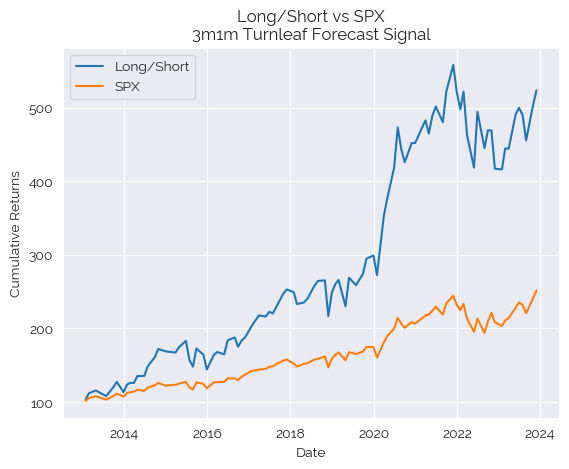

In [445]:
lookback = 60
lookback_rtn_col = 3 
weights_factor='3M_rising_yoy'
rtn_col = 'rtn_1M'
npairs = 3

dfres, returns = plot_ls_trading_rule(df_all, dftlX, dfrtn, tlfactor=tlfactor, rtn_col=rtn_col, 
                     weights_lookback=lookback, fwd_period=12, weights_factor=weights_factor, 
                                      vols=vols, vol_weight=True, npairs=npairs, short_spx=True, long_only=True)

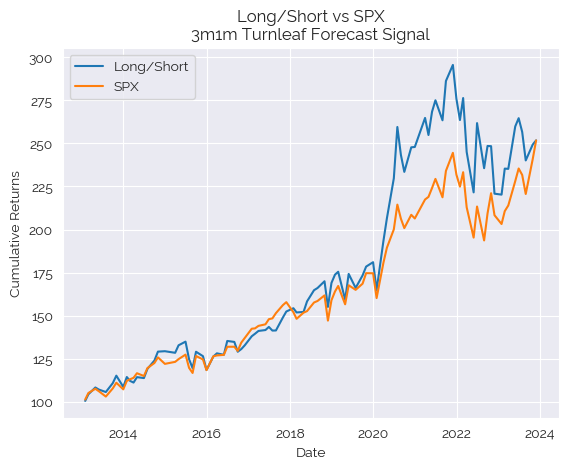

In [436]:
lookback = 36
lookback_rtn_col = 3 
weights_factor='3M_rising_yoy'
rtn_col = 'rtn_1M'
npairs=3

dfres, returns = plot_ls_trading_rule(df_all, dftlX, dfrtn, tlfactor=tlfactor, rtn_col=rtn_col, 
                     weights_lookback=lookback, fwd_period=12, weights_factor=weights_factor, 
                                      vols=vols, vol_weight=True, npairs=npairs, short_spx=False)

In [418]:
df_all.to_clipboard()

In [280]:
vols

,sym,date,refmonthyear,rtn_1M
0,s5cond,1989-10-31,OCT.1989,NaN
1,s5cond,1989-11-30,NOV.1989,NaN
2,s5cond,1989-12-29,DEC.1989,NaN
3,s5cond,1990-01-31,JAN.1990,NaN
4,s5cond,1990-02-28,FEB.1990,NaN
...,...,...,...,...
3730,spx,2023-12-29,DEC.2023,0.139917
3731,spx,2024-01-31,JAN.2024,0.136605
3732,spx,2024-02-29,FEB.2024,0.136188
3733,spx,2024-03-29,MAR.2024,0.141959


In [ ]:
lookback = 36
lookback_rtn_col = 3 
weights_factor='3M_rising_yoy'
rtn_col = 'rtn_1M'

dfres, returns = plot_ls_trading_rule(df_all, dftlX, dfrtn, tlfactor=tlfactor, rtn_col=rtn_col, 
                     weights_lookback=lookback, fwd_period=12, weights_factor=weights_factor, 
                                      vols=vols, vol_weight=True, npairs=3, short_spx=True)